In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


In [30]:
df = pd.read_csv('/content/heart_disease.csv')

df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


In [31]:
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

Missing values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64
Duplicates: 0


In [32]:
# Replace numeric nulls with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Replace object/categorical nulls with mode (future-proof)
for col in df.select_dtypes(include='object').columns:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val).infer_objects(copy=False)

print(df.isnull().sum())


id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


/tmp/ipython-input-32-3449864471.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(mode_val).infer_objects(copy=False)


In [33]:
def cap_outliers_iqr(df_in, cols, k=1.5):
    df_out = df_in.copy()
    for c in cols:
        Q1 = df_out[c].quantile(0.25)
        Q3 = df_out[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        df_out[c] = df_out[c].clip(lower, upper)
    return df_out

numeric_cols = df.select_dtypes(include='number').columns.tolist()
df_capped = cap_outliers_iqr(df, numeric_cols)


df_capped.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
id,920.0,459.500000,265.725422,0.000,229.75,459.5,689.25,919.000
age,920.0,53.510870,9.424685,28.000,47.00,54.0,60.00,77.000
trestbps,920.0,131.725000,16.921872,90.000,120.00,130.0,140.00,170.000
chol,920.0,207.095516,91.530131,43.875,177.75,223.0,267.00,400.875
thalch,920.0,137.702174,25.116321,66.000,120.00,140.0,156.00,202.000
oldpeak,920.0,0.843696,1.022640,-2.250,0.00,0.5,1.50,3.750
ca,920.0,0.000000,0.000000,0.000,0.00,0.0,0.00,0.000


In [34]:
# Standard Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_capped[numeric_cols]), columns=numeric_cols)

Best k by silhouette score: 2


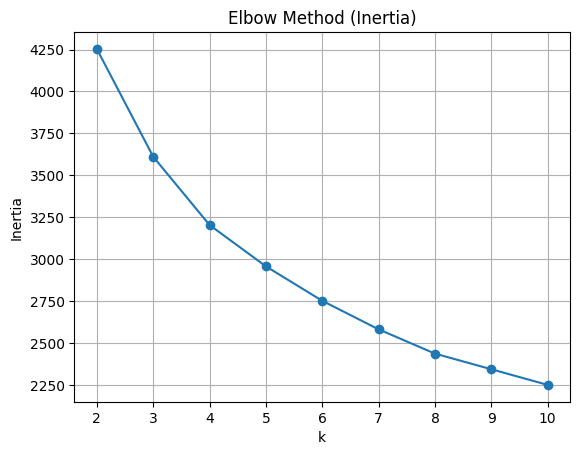

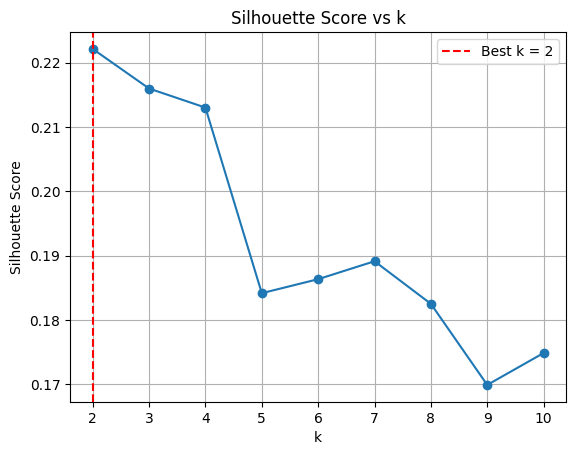

In [35]:
# Find optimal k for KMeans
ks = range(2, 11)
inertias = []
sil_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

best_k = ks[sil_scores.index(max(sil_scores))]
print("Best k by silhouette score:", best_k)

# Plot Elbow
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Plot Silhouette Scores
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f"Best k = {best_k}")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# KMeans clustering with best_k
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)
sil = silhouette_score(X_scaled, labels_km)
print("Silhouette score:", round(sil, 4))

unique, counts = np.unique(labels_km, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

Silhouette score: 0.2221
Cluster 0: 405 samples
Cluster 1: 515 samples


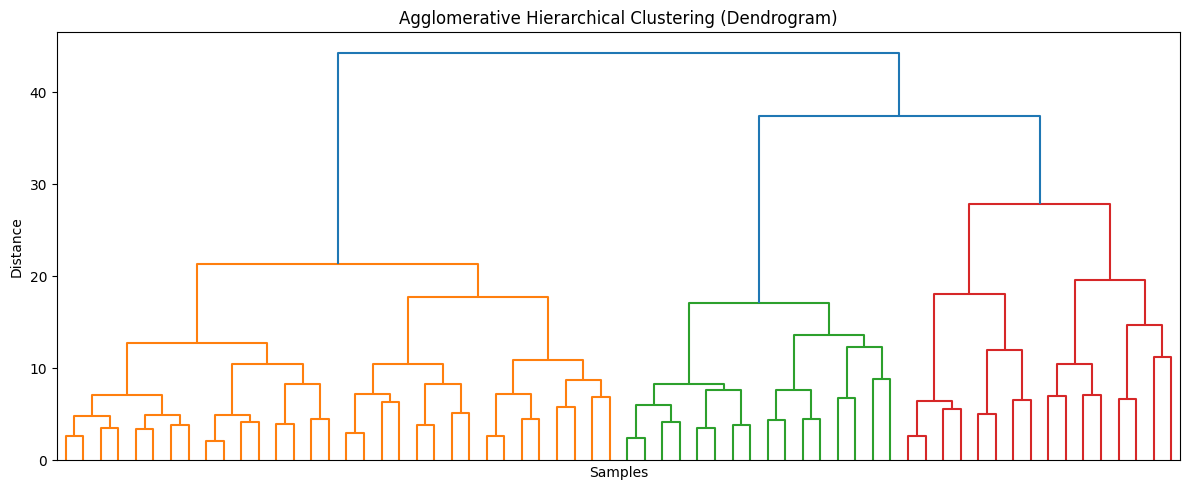

In [37]:
# Agglomerative Clustering - Dendrogram
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode="level", p=5, no_labels=True)
plt.title("Agglomerative Hierarchical Clustering (Dendrogram)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [38]:
# Bisecting KMeans Implementation
def bisecting_kmeans_tree(X, k=2, random_state=42, n_init=10):
    clusters = {0: X.index}
    next_id = 1
    tree = []
    labels = pd.Series(np.zeros(len(X), dtype=int), index=X.index)

    while len(clusters) < k:
        to_split = max(clusters, key=lambda cid: len(clusters[cid]))
        idx = clusters[to_split]
        km = KMeans(n_clusters=2, n_init=n_init, random_state=random_state).fit(X.loc[idx])
        left_idx = idx[km.labels_ == 0]
        right_idx = idx[km.labels_ == 1]

        left_id = next_id
        right_id = next_id + 1
        next_id += 2

        clusters[left_id] = left_idx
        clusters[right_id] = right_idx
        del clusters[to_split]

        labels[left_idx] = left_id
        labels[right_idx] = right_id
        tree.append((to_split, left_id, right_id))

    remap = {old: new for new, old in enumerate(sorted(clusters))}
    final_labels = labels.map(remap)

    return final_labels, tree

labels_div, tree_div = bisecting_kmeans_tree(X_scaled, k=best_k)

print("Cluster sizes:")
print(labels_div.value_counts().sort_index())
print("\nTree Structure (parent → left, right):")
for p, l, r in tree_div:
    print(f"{p} → {l}, {r}")

Cluster sizes:
0    405
1    515
Name: count, dtype: int64

Tree Structure (parent → left, right):
0 → 1, 2


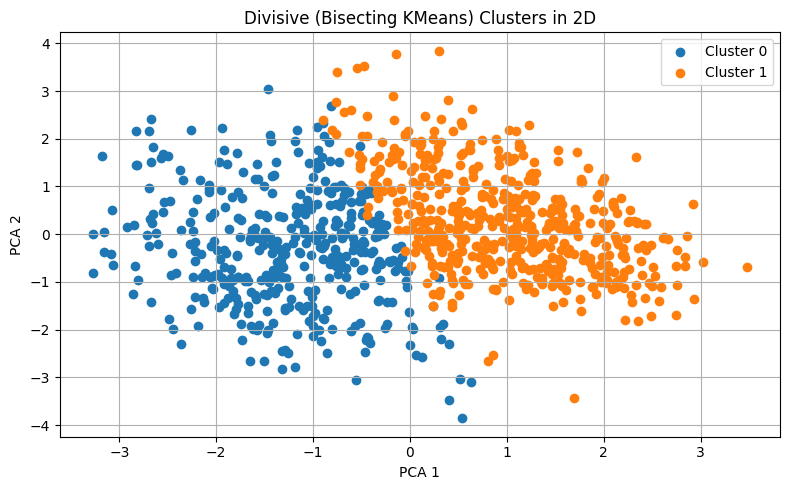

In [39]:
# PCA for Visualization (2D)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Plot Bisecting KMeans
final_labels = labels_div.values
plt.figure(figsize=(8, 5))
for label in np.unique(final_labels):
    plt.scatter(
        X_2d[final_labels == label, 0],
        X_2d[final_labels == label, 1],
        label=f"Cluster {label}"
    )
plt.title("Divisive (Bisecting KMeans) Clusters in 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


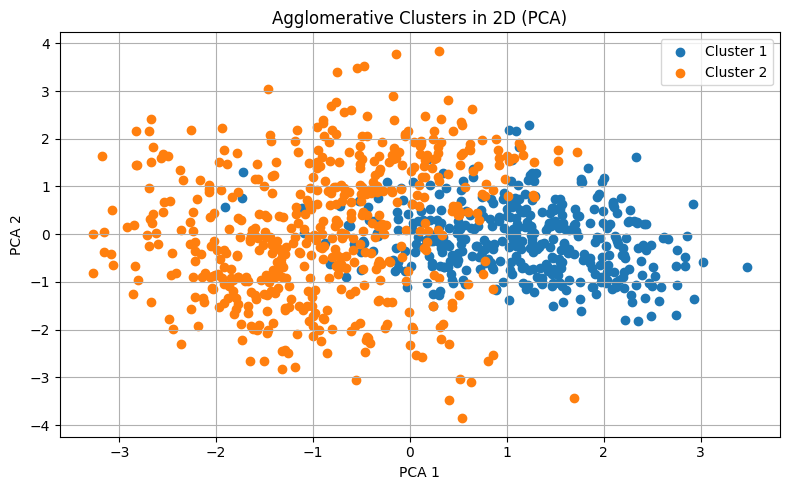

In [40]:
# Plot Agglomerative Clustering
agglo_labels = fcluster(Z, t=best_k, criterion='maxclust')
plt.figure(figsize=(8, 5))
for label in np.unique(agglo_labels):
    plt.scatter(
        X_2d[agglo_labels == label, 0],
        X_2d[agglo_labels == label, 1],
        label=f"Cluster {label}"
    )
plt.title("Agglomerative Clusters in 2D (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()